# Convolutional Neural Networks

## Project: Dog Breed Classification with Transfer Learning 

---
## Step 0: Import Libraries

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import os

from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models

---
## Step 1: Download The Dataset

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip). 

In [2]:
dog_files = np.array(glob("/data/dog_images/*/*/*"))
print('There are %d total dog images.' % len(dog_files))

There are 8351 total dog images.


---
## Step 2: View Sample of Images

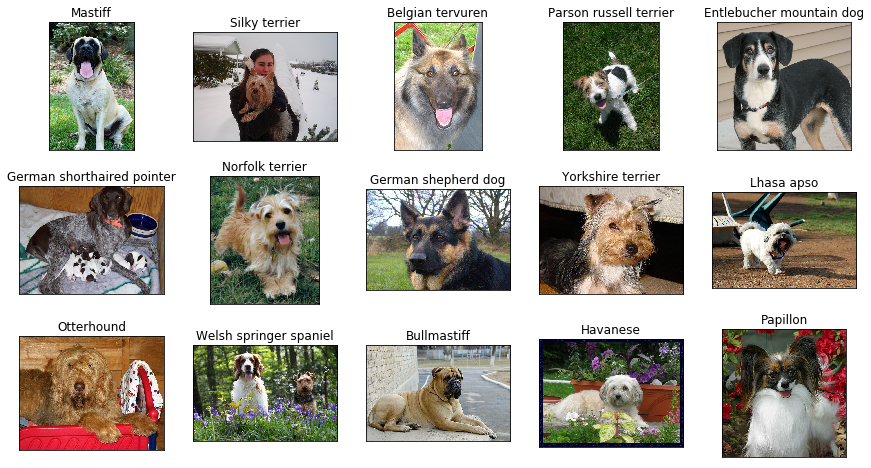

In [3]:
fig = plt.figure(figsize=(15, 8))
sample_size = 15
rows = 3
sample = np.random.randint(len(dog_files), size=sample_size)
for i, s in enumerate(sample):
    filename = os.path.basename(dog_files[s])
    img = Image.open(dog_files[s])
    plt.subplot(rows, sample_size / rows, i + 1)
    dog_name = filename[:-10].replace("_", " ")
    plt.title(dog_name)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

## Step 3: Data Pre-processing

Create data loaders so that we can feed the data into the network models.

In [4]:
# create data loaders via transformers
class MyComposedTransformer:
    def __init__(self, image_size, has_augmentation=False, is_normalized=True):
        self.transforms = []
        self.transforms.append(T.Resize(size=image_size))
        if has_augmentation:
            self.transforms.append(T.RandomAffine(degrees=20, translate=(.2, .2)))
            self.transforms.append(T.RandomHorizontalFlip())
        self.transforms.append(T.ToTensor())    
        if is_normalized:
            self.transforms.append(T.Normalize((0.4870, 0.4665, 0.3972), (0.2278, 0.2232, 0.2228)))

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

def get_data_loaders(num_workers, image_dim=128, has_augmentation=False, is_normalized=True):
    # directories
    training_dir = '/data/dog_images/train/'
    validation_dir = '/data/dog_images/valid/'
    testing_dir = '/data/dog_images/test/'
    
    # training parameters
    image_size = (image_dim, image_dim)
    batch_size = 32
        
    image_transformer_train = MyComposedTransformer(image_size, has_augmentation, is_normalized)
    image_transformer_test = MyComposedTransformer(image_size, False, is_normalized)

    train_data = datasets.ImageFolder(training_dir, transform=image_transformer_train)
    valid_data = datasets.ImageFolder(validation_dir, transform=image_transformer_test)
    test_data = datasets.ImageFolder(testing_dir, transform=image_transformer_test)

    train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    class_names = [item[4:].replace("_", " ") for item in train_data.classes]
    data_loaders = {'train': train_loader, 'valid': val_loader, 'test': test_loader}
    
    # print number of images in each set
    print('Training images: ', len(train_data))
    print('Validation images: ', len(valid_data))
    print('Testing images: ', len(test_data))
    print('Number of Categories:', len(class_names))
    
    return data_loaders, class_names

### Calculate Mean and Standard Deviation to Normalize

In [5]:
def get_mean_and_std(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data, _ in data_loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    print('mean={}'.format(mean))
    print('std={}'.format(std))

num_workers = 0
data_loaders, _ = get_data_loaders(num_workers, image_dim=256, has_augmentation=False, is_normalized=False)
get_mean_and_std(data_loaders['train'])

Training images:  6680
Validation images:  835
Testing images:  836
Number of Categories: 133
mean=tensor([ 0.4870,  0.4665,  0.3972])
std=tensor([ 0.2286,  0.2239,  0.2236])


## Step 4: Examine Augmented Images

Check that augmented images seem reasonble

Training images:  6680
Validation images:  835
Testing:  836


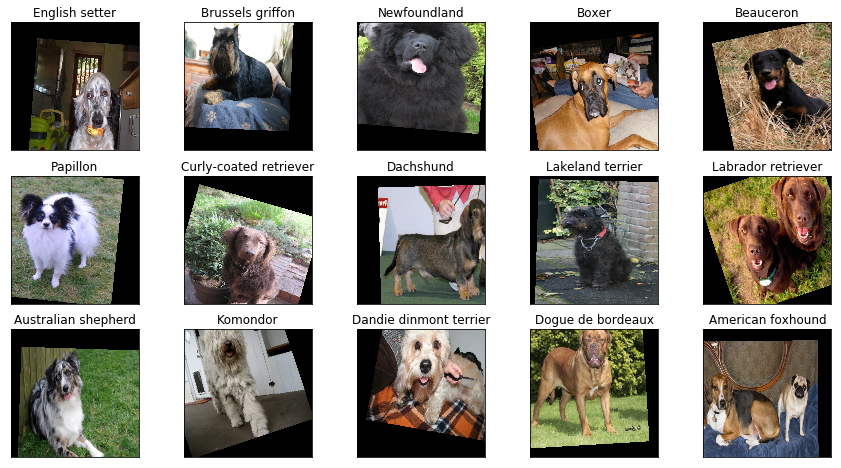

In [45]:
data_loaders, class_names = get_data_loaders(image_dim=256, has_augmentation=True, is_normalized=False)
train_iter = iter(data_loaders['train'])
images, labels = next(train_iter)
images, labels = images.numpy(), labels.numpy()

sample_size = 15
fig = plt.figure(figsize=(15, 8))
for i in range(sample_size):
    plt.subplot(3, 5, i + 1)
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    plt.title(class_names[labels[i]])
    plt.xticks([])
    plt.yticks([])

## Step 5: Create Model Architectures

Create CNNs to classify dog breeds. Create a total of 3, 
1. Benchmark Model
2. Improved Benchmark Model
3. Pre-trained Model from Transfer Learning with VGG16

An improved pre-trained model will be trained by using image augmentation and an improved Benchmark model will have batch normalization and dropout layers.

In [5]:
class BenchmarkNet(nn.Module):
    def __init__(self, num_classes, image_size):
        super(BenchmarkNet, self).__init__()
        self.conv_out_size = image_size / 2**2 # 2 max-pool layers
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(self.conv_out_size**2 * 64, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))        
        x = x.view(-1, self.conv_out_size**2 * 64)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x
    

class ImprovedBenchmarkNet(nn.Module):
    def __init__(self, num_classes, image_size):
        super(ImprovedBenchmarkNet, self).__init__()
        self.conv_out_size = image_size / 2**2
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        self.cbn3 = nn.BatchNorm2d(64)
        self.cdrop = nn.Dropout2d(.20)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(self.conv_out_size**2 * 64, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.cbn3(self.conv3(x)))
        x = self.cdrop(x)
        x = x.view(-1, self.conv_out_size**2 * 64)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x
    
def get_pretrained_model(num_classes):    
    model_transfer = models.vgg16(pretrained=True)
    
    # fix weights
    for param in model_transfer.features.parameters():
        param.requires_grad = False
    
    # create custom layer
    num_inputs = model_transfer.classifier[6].in_features
    last_layer = nn.Linear(num_inputs, num_classes)
    
    # replace last layer with custom layer
    model_transfer.classifier[6] = last_layer
    return model_transfer

## Step 6: Define Train and Testing Code

In [6]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    train_accuracies = []
    val_accuracies = []
    
    train_losses = []
    val_losses = []
    
    num_train_batches = len(loaders['train'])
    num_val_batches = len(loaders['valid'])
    
    print_every = 100
    for epoch in range(1, n_epochs + 1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        correct = 0
        total = 0
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # gradient step
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            # calc accuracy
            pred = output.data.max(1, keepdim=True)[1]
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)
            if batch_idx % print_every == 0:
                print("epoch={}, batch={}/{}, loss={}"
                  .format(epoch, batch_idx + 1, num_train_batches, loss.item()))
            
        avg_train_loss = train_loss / num_train_batches
        train_acc = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()
            
            # calc accuracy
            pred = output.data.max(1, keepdim=True)[1]
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)

        avg_valid_loss = valid_loss / num_val_batches
        val_acc = correct / total
        val_losses.append(avg_valid_loss)
        val_accuracies.append(val_acc)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.3f} \tValidation Loss: {:.3f}'.format(
            epoch, avg_train_loss, avg_valid_loss))
        print('Training Accuracy: {:.2f} \tValidation Accuracy: {:.2f}'.format(
            train_acc, val_acc))
        
        # save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
        
    # return trained model
    stats = {'train_losses': train_losses, 'val_losses': val_losses,
          'train_accs': train_accuracies, 'val_accs': val_accuracies}
    return model, stats


def test(loaders, model, criterion, use_cuda):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        # predict
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    
    # print loss and accuracy
    test_accuracy = 100. * correct / total 
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        test_accuracy, correct, total))
    
    return {'test_acc': [test_accuracy], 'test_loss': [test_loss.item()]}


## Step 7: Train and Test Models

### Benchmark Model

In [7]:
# initiate the model and training requirements
use_cuda = torch.cuda.is_available()
image_dim = 128
image_size = (image_dim, image_dim)

num_workers = 1
data_loaders, class_names = get_data_loaders(num_workers, image_dim, has_augmentation=False, is_normalized=True)
num_classes = len(class_names)

model = BenchmarkNet(num_classes, image_dim)
if use_cuda:
    model = model.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.1)
num_epochs = 20

# train model
model, stats_scratch = train(num_epochs, 
                             data_loaders, 
                             model, 
                             optimizer, 
                             criterion, 
                             use_cuda, 
                             'model_scratch.pt')
# save results
pd.DataFrame(stats_scratch).to_csv('stats_scratch.csv', index=False)

# test model
model.load_state_dict(torch.load('model_scratch.pt'))
test_results_scratch = test(data_loaders, 
                            model, 
                            criterion, 
                            use_cuda)
# save results
pd.DataFrame(test_results_scratch).to_csv('test_results_scratch.csv', index=False)

Training images:  6680
Validation images:  835
Testing images:  836
Number of Categories: 133
epoch=1, batch=1/209, loss=4.890806674957275
epoch=1, batch=101/209, loss=4.860018730163574
epoch=1, batch=201/209, loss=4.756251335144043
Epoch: 1 	Training Loss: 4.825 	Validation Loss: 4.680
Training Accuracy: 0.01 	Validation Accuracy: 0.03
epoch=2, batch=1/209, loss=4.591681957244873
epoch=2, batch=101/209, loss=4.587978839874268
epoch=2, batch=201/209, loss=4.688855171203613
Epoch: 2 	Training Loss: 4.606 	Validation Loss: 4.635
Training Accuracy: 0.03 	Validation Accuracy: 0.03
epoch=3, batch=1/209, loss=4.56326961517334
epoch=3, batch=101/209, loss=4.313075542449951
epoch=3, batch=201/209, loss=4.348572254180908
Epoch: 3 	Training Loss: 4.478 	Validation Loss: 4.688
Training Accuracy: 0.04 	Validation Accuracy: 0.03
epoch=4, batch=1/209, loss=4.51983118057251
epoch=4, batch=101/209, loss=4.390140056610107
epoch=4, batch=201/209, loss=4.322385311126709
Epoch: 4 	Training Loss: 4.262 	Va

### Improved Benchmark Model

In [8]:
# initiate the model and training requirements
use_cuda = torch.cuda.is_available()
image_dim = 128
image_size = (image_dim, image_dim)

num_workers = 1
data_loaders, class_names = get_data_loaders(num_workers, image_dim, has_augmentation=True, is_normalized=True)
num_classes = len(class_names)

model = ImprovedBenchmarkNet(num_classes, image_size[0])
if use_cuda:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.1)
num_epochs = 20

# train model
model, stats_scratch = train(num_epochs, 
                             data_loaders, 
                             model, 
                             optimizer, 
                             criterion, 
                             use_cuda, 
                             'model_scratch.pt')
# save results
pd.DataFrame(stats_scratch).to_csv('stats_scratch.csv', index=False)

# test model
model.load_state_dict(torch.load('model_scratch.pt'))
test_results_scratch = test(data_loaders, 
                            model, 
                            criterion, 
                            use_cuda)
# save results
pd.DataFrame(test_results_scratch).to_csv('test_results_scratch.csv', index=False)

Training images:  6680
Validation images:  835
Testing images:  836
Number of Categories: 133
epoch=1, batch=1/209, loss=4.908221244812012
epoch=1, batch=101/209, loss=4.864504337310791
epoch=1, batch=201/209, loss=4.649991989135742
Epoch: 1 	Training Loss: 4.724 	Validation Loss: 4.520
Training Accuracy: 0.02 	Validation Accuracy: 0.04
epoch=2, batch=1/209, loss=4.490774631500244
epoch=2, batch=101/209, loss=4.551568508148193
epoch=2, batch=201/209, loss=4.3175578117370605
Epoch: 2 	Training Loss: 4.429 	Validation Loss: 4.208
Training Accuracy: 0.04 	Validation Accuracy: 0.06
epoch=3, batch=1/209, loss=4.102909088134766
epoch=3, batch=101/209, loss=4.3379225730896
epoch=3, batch=201/209, loss=4.19911527633667
Epoch: 3 	Training Loss: 4.272 	Validation Loss: 4.341
Training Accuracy: 0.05 	Validation Accuracy: 0.05
epoch=4, batch=1/209, loss=4.0530900955200195
epoch=4, batch=101/209, loss=4.031765937805176
epoch=4, batch=201/209, loss=4.043935775756836
Epoch: 4 	Training Loss: 4.156 	V

### Pre-trained Model from VGG16

In [9]:
# initiate the model and training requirements
use_cuda = torch.cuda.is_available()
image_dim = 224
image_size = (image_dim, image_dim)

num_workers = 1
data_loaders, class_names = get_data_loaders(num_workers, image_dim, has_augmentation=False, is_normalized=True)
num_classes = len(class_names)

model = get_pretrained_model(num_classes)
if use_cuda:
    model = model.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=.001)
num_epochs = 20

# train model
model, stats_transfer = train(num_epochs, 
                             data_loaders, 
                             model, 
                             optimizer, 
                             criterion, 
                             use_cuda, 
                             'model_transfer.pt')
# save results
pd.DataFrame(stats_transfer).to_csv('stats_transfer.csv', index=False)

# test model
model.load_state_dict(torch.load('model_transfer.pt'))
test_results_transfer = test(data_loaders, 
                            model, 
                            criterion, 
                            use_cuda)
# save results
pd.DataFrame(test_results_transfer).to_csv('test_results_transfer.csv', index=False)

Training images:  6680
Validation images:  835
Testing images:  836
Number of Categories: 133
epoch=1, batch=1/209, loss=5.10582971572876
epoch=1, batch=101/209, loss=4.233680248260498
epoch=1, batch=201/209, loss=3.4476194381713867
Epoch: 1 	Training Loss: 4.211 	Validation Loss: 3.143
Training Accuracy: 0.16 	Validation Accuracy: 0.54
epoch=2, batch=1/209, loss=3.333205223083496
epoch=2, batch=101/209, loss=2.47121262550354
epoch=2, batch=201/209, loss=1.499041199684143
Epoch: 2 	Training Loss: 2.487 	Validation Loss: 1.607
Training Accuracy: 0.51 	Validation Accuracy: 0.69
epoch=3, batch=1/209, loss=1.5165764093399048
epoch=3, batch=101/209, loss=1.4913772344589233
epoch=3, batch=201/209, loss=1.5957850217819214
Epoch: 3 	Training Loss: 1.435 	Validation Loss: 0.961
Training Accuracy: 0.66 	Validation Accuracy: 0.77
epoch=4, batch=1/209, loss=1.2102965116500854
epoch=4, batch=101/209, loss=1.1426535844802856
epoch=4, batch=201/209, loss=1.2348052263259888
Epoch: 4 	Training Loss: 1.

### Pre-trained Model from VGG16 with Image Augmentation

In [10]:
# initiate the model and training requirements
use_cuda = torch.cuda.is_available()
image_dim = 224
image_size = (image_dim, image_dim)

num_workers = 1
data_loaders, class_names = get_data_loaders(num_workers, image_dim, has_augmentation=True, is_normalized=True)
num_classes = len(class_names)

model = get_pretrained_model(num_classes)
if use_cuda:
    model = model.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=.001)
num_epochs = 20

# train model
model, stats_transfer = train(num_epochs, 
                             data_loaders, 
                             model, 
                             optimizer, 
                             criterion, 
                             use_cuda, 
                             'model_transfer.pt')
# save results
pd.DataFrame(stats_transfer).to_csv('stats_transfer.csv', index=False)

# test model
model.load_state_dict(torch.load('model_transfer.pt'))
test_results_transfer = test(data_loaders, 
                            model, 
                            criterion, 
                            use_cuda)
# save results
pd.DataFrame(test_results_transfer).to_csv('test_results_transfer.csv', index=False)

Training images:  6680
Validation images:  835
Testing images:  836
Number of Categories: 133
epoch=1, batch=1/209, loss=5.161958694458008
epoch=1, batch=101/209, loss=4.652472019195557
epoch=1, batch=201/209, loss=4.030969142913818
Epoch: 1 	Training Loss: 4.508 	Validation Loss: 3.635
Training Accuracy: 0.09 	Validation Accuracy: 0.44
epoch=2, batch=1/209, loss=3.8737268447875977
epoch=2, batch=101/209, loss=3.3510212898254395
epoch=2, batch=201/209, loss=2.578662395477295
Epoch: 2 	Training Loss: 3.259 	Validation Loss: 2.150
Training Accuracy: 0.36 	Validation Accuracy: 0.62
epoch=3, batch=1/209, loss=2.8543155193328857
epoch=3, batch=101/209, loss=2.1268768310546875
epoch=3, batch=201/209, loss=1.594977855682373
Epoch: 3 	Training Loss: 2.195 	Validation Loss: 1.335
Training Accuracy: 0.52 	Validation Accuracy: 0.69
epoch=4, batch=1/209, loss=1.5729529857635498
epoch=4, batch=101/209, loss=1.1978365182876587
epoch=4, batch=201/209, loss=1.3703243732452393
Epoch: 4 	Training Loss: 

## 8. Training Plots

In [34]:
def plot_training(stats_file, model_name, test_result_file):
    training_df = pd.read_csv(stats_file)

    epochs, _ = training_df.shape
    epochs = range(1, epochs + 1, 1)
    plt.figure(figsize=(15, 5))
    
    # plot accuracy vs epochs
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_df.train_accs, label='training')
    plt.plot(epochs, training_df.val_accs, label='validation')
    plt.legend()
    plt.title('{}: Accuracy'.format(model_name))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    
    # plot loss vs epochs
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_df.train_losses, label='training')
    plt.plot(epochs, training_df.val_losses, label='validation')
    plt.legend()
    plt.title('{}: Loss'.format(model_name))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim((0, 20))
    
    # display test accuracy and loss
    test_df = pd.read_csv(test_result_file)
    result = test_df.iloc[0]
    print('test accuracy: {:.3f}, test loss: {:.3f}'.format(result['test_acc'], result['test_loss']))

### Bechmark Model

test accuracy: 6.100, test loss: 4.253


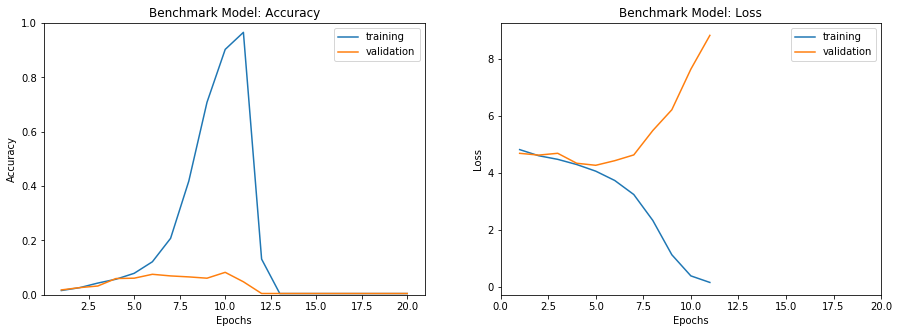

In [32]:
stats_file = 'stats_scratch_no_augmentation.csv'
model_name = 'Benchmark Model'
test_result_file = 'test_results_scratch_no_augmentation.csv'
plot_training(stats_file, model_name, test_result_file)

### Pre-Trained Model

test accuracy: 86.364, test loss: 0.465


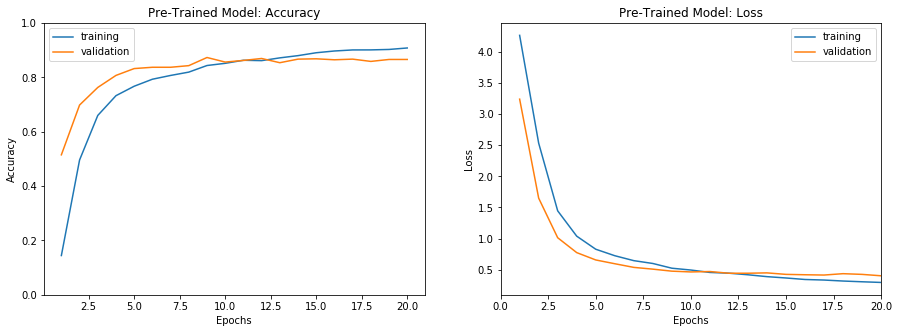

In [33]:
stats_file = 'stats_transfer_no_augmentation.csv'
model_name = 'Pre-Trained Model'
test_result_file = 'test_results_transfer_no_augmentation.csv'
plot_training(stats_file, model_name, test_result_file)

### Improved Benchmark Model

test accuracy: 16.507, test loss: 3.578


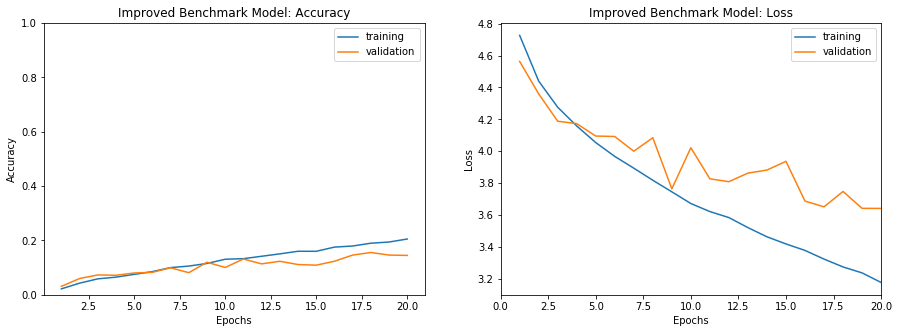

In [35]:
stats_file = 'stats_scratch_improved.csv'
model_name = 'Improved Benchmark Model'
test_result_file = 'test_results_scratch_improved.csv'
plot_training(stats_file, model_name, test_result_file)

### Pre-Trained Model with Augmentation

test accuracy: 85.048, test loss: 0.547


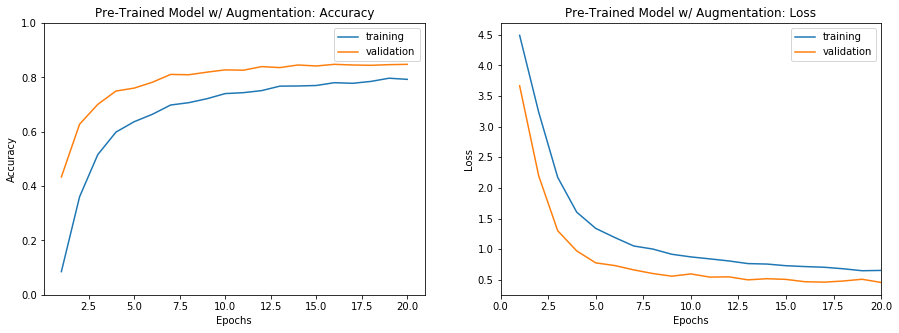

In [36]:
stats_file = 'stats_transfer_augmentation.csv'
model_name = 'Pre-Trained Model w/ Augmentation'
test_result_file = 'test_results_transfer_augmentation.csv'
plot_training(stats_file, model_name, test_result_file)